In [17]:
import os
import re
from collections import defaultdict
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

root_dir = '/home/jovyan/fokin/modded-nanogpt/runs'

# Get a list of all experiment folders
logdirs = [os.path.join(root_dir, d, 'tensorboard_logs') for d in os.listdir(root_dir) \
           if (('26.01' in d) or ('27.01' in d) or ('26.12' in d) or ('27.12' in d))]

In [18]:
def group_by_k_and_hyp(paths):
    groups_ts = defaultdict(list)  # Group for `hyp` numbers
    groups_fw = defaultdict(list)  # Group for `k` numbers and `euc`
    
    # Define the regex patterns
    k_pattern = re.compile(r'k_([\d.]+)')  # Matches numbers after `k_`
    hyp_pattern = re.compile(r'hyp_([\d.]+)')  # Matches numbers after `hyp_`
    
    for path in paths:
        # Check for `euc` in the path name
        if 'euc' in path:
            groups_fw['euc'].append(path)
            continue
        
        # Check for `k` and extract the number
        k_match = k_pattern.search(path)
        if k_match:
            key = f'{k_match.group(1)}'
            groups_fw[key].append(path)
            continue
        
        # Check for `hyp` and extract the number
        hyp_match = hyp_pattern.search(path)
        if hyp_match:
            key = f'{hyp_match.group(1)}'
            groups_ts[key].append(path)
    
    return dict(groups_ts), dict(groups_fw)

result1, result2 = group_by_k_and_hyp(logdirs)
result1.keys(), result2.keys()

(dict_keys(['90.0', '120.0', '150.0', '180.0', '210.0', '240.0']),
 dict_keys(['euc', '1.0', '100.0', '500.0']))

In [29]:
import os
from tensorboard.backend.event_processing import event_accumulator

def load_tensorboard_logs(groups):
    def extract_scalars(log_path, tag):
        # Load TensorBoard logs
        if not os.path.exists(log_path):
            print(f"Path does not exist: {log_path}")
            return []
        try:
            ea = event_accumulator.EventAccumulator(log_path)
            ea.Reload()
            if tag in ea.Tags().get('scalars', []):
                scalars = ea.Scalars(tag)
                return [(event.step, event.value)for event in scalars]
            else:
                print(f"Tag '{tag}' not found in {log_path}")
                return []
        except Exception as e:
            print(f"Failed to load {log_path}: {e}")
            return []
    
    results = {}
    for group, paths in groups.items():
        train = []
        val = []
        train_lengths = []
        val_lengths = []
        for path in paths:
            train_losses = extract_scalars(path, 'Loss/Train')
            val_losses = extract_scalars(path, 'Loss/Validation')
            train.append(train_losses)
            val.append(val_losses)
            train_lengths.append(len(train_losses))
            val_lengths.append(len(val_losses))
        
        print(f"Group '{group}':")
        print(f"  Train lengths: {train_lengths}")
        print(f"  Validation lengths: {val_lengths}")
        results[group] = {"Train": train, "Validation": val}
    
    return results

res_plots = load_tensorboard_logs(result2)

Group 'euc':
  Train lengths: [500, 500, 500, 500, 500]
  Validation lengths: [501, 501, 501, 501, 501]
Group '1.0':
  Train lengths: [500, 500, 500, 500, 500, 500]
  Validation lengths: [501, 501, 501, 501, 501, 501]
Group '100.0':
  Train lengths: [500, 500, 500, 500, 500]
  Validation lengths: [501, 501, 501, 501, 501]
Group '500.0':
  Train lengths: [500, 500, 500, 500, 500]
  Validation lengths: [501, 501, 501, 501, 501]


In [46]:
for split, plots in res_plots['1.0'].items():
    for p in plots:
        ar = [v for _, v in p[490:]]
        print(np.mean(ar))

4.635919284820557
4.634364652633667
4.639618968963623
6.147640943527222
4.638400506973267
4.64145302772522
4.613665840842507
4.6127168048511855
4.617965438149192
6.130246942693537
4.616333874789151
4.619674422524192


In [52]:
import os
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

def load_tensorboard_logs_th(groups, threshold=None):
    def extract_scalars(log_path, tag):
        # Load TensorBoard logs
        if not os.path.exists(log_path):
            print(f"Path does not exist: {log_path}")
            return []
        try:
            ea = event_accumulator.EventAccumulator(log_path)
            ea.Reload()
            if tag in ea.Tags().get('scalars', []):
                scalars = ea.Scalars(tag)
                return [(event.step, event.value) for event in scalars]
            else:
                print(f"Tag '{tag}' not found in {log_path}")
                return []
        except Exception as e:
            print(f"Failed to load {log_path}: {e}")
            return []
    
    results = {}
    for group, paths in groups.items():
        train = []
        val = []
        train_lengths = []
        val_lengths = []
        for path in paths:
            train_losses = extract_scalars(path, 'Loss/Train')
            val_losses = extract_scalars(path, 'Loss/Validation')

            # Apply threshold filtering if specified
            if threshold is not None:
                if len(train_losses) > 490:
                    train_ar = [v for _, v in train_losses[490:]]
                    train_mean = np.mean(train_ar)
                else:
                    train_mean = float('inf')

                if len(val_losses) > 490:
                    val_ar = [v for _, v in val_losses[490:]]
                    val_mean = np.mean(val_ar)
                else:
                    val_mean = float('inf')

                print(f"Path: {path}")
                print(f"  Train Mean (steps 490+): {train_mean}")
                print(f"  Validation Mean (steps 490+): {val_mean}")

                # Keep only plots where the mean <= threshold
                if train_mean <= threshold:
                    train.append(train_losses)
                else:
                    print(f"  Excluding Train plot due to high mean.")

                if val_mean <= threshold:
                    val.append(val_losses)
                else:
                    print(f"  Excluding Validation plot due to high mean.")
            else:
                train.append(train_losses)
                val.append(val_losses)
            
            train_lengths.append(len(train_losses))
            val_lengths.append(len(val_losses))
        
        print(f"Group '{group}':")
        print(f"  Train lengths: {train_lengths}")
        print(f"  Validation lengths: {val_lengths}")
        results[group] = {"Train": train, "Validation": val}
    
    return results

# Usage Example
threshold = 5.0
res_plots = load_tensorboard_logs_th(result2, threshold=threshold)

Path: /home/jovyan/fokin/modded-nanogpt/runs/27.01_3409_euc_head_3/tensorboard_logs
  Train Mean (steps 490+): 4.5501926898956295
  Validation Mean (steps 490+): 4.540777639909224
Path: /home/jovyan/fokin/modded-nanogpt/runs/27.01_8362_euc_head_4/tensorboard_logs
  Train Mean (steps 490+): 4.538603687286377
  Validation Mean (steps 490+): 4.529028372331099
Path: /home/jovyan/fokin/modded-nanogpt/runs/26.01_82055_euc_head_1/tensorboard_logs
  Train Mean (steps 490+): 4.543084669113159
  Validation Mean (steps 490+): 4.521864154122093
Path: /home/jovyan/fokin/modded-nanogpt/runs/26.01_84876_euc_head_2/tensorboard_logs
  Train Mean (steps 490+): 4.513500928878784
  Validation Mean (steps 490+): 4.503118991851807
Path: /home/jovyan/fokin/modded-nanogpt/runs/26.01_65527_euc_head_0/tensorboard_logs
  Train Mean (steps 490+): 4.531473159790039
  Validation Mean (steps 490+): 4.509859908710826
Group 'euc':
  Train lengths: [500, 500, 500, 500, 500]
  Validation lengths: [501, 501, 501, 501, 50

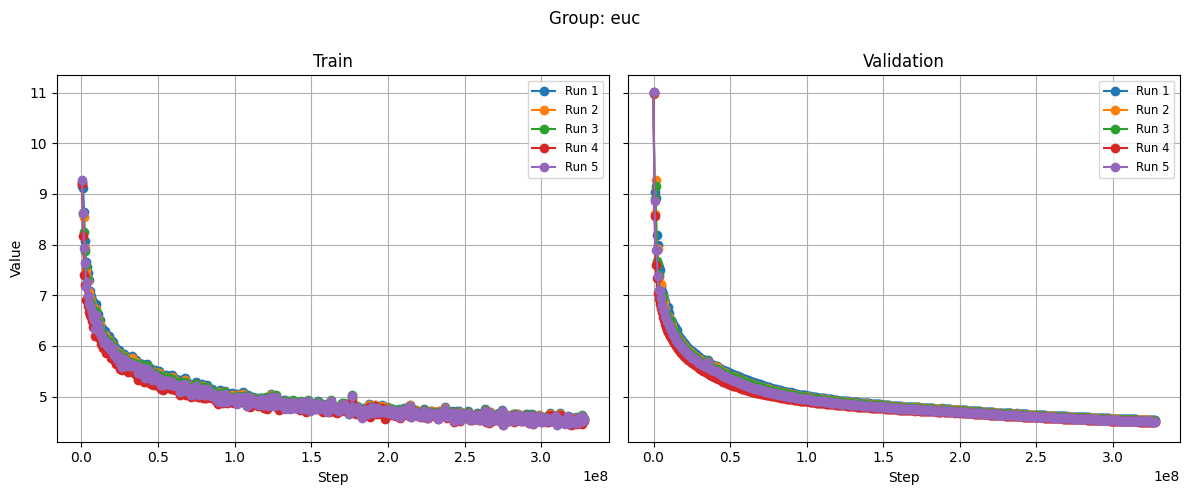

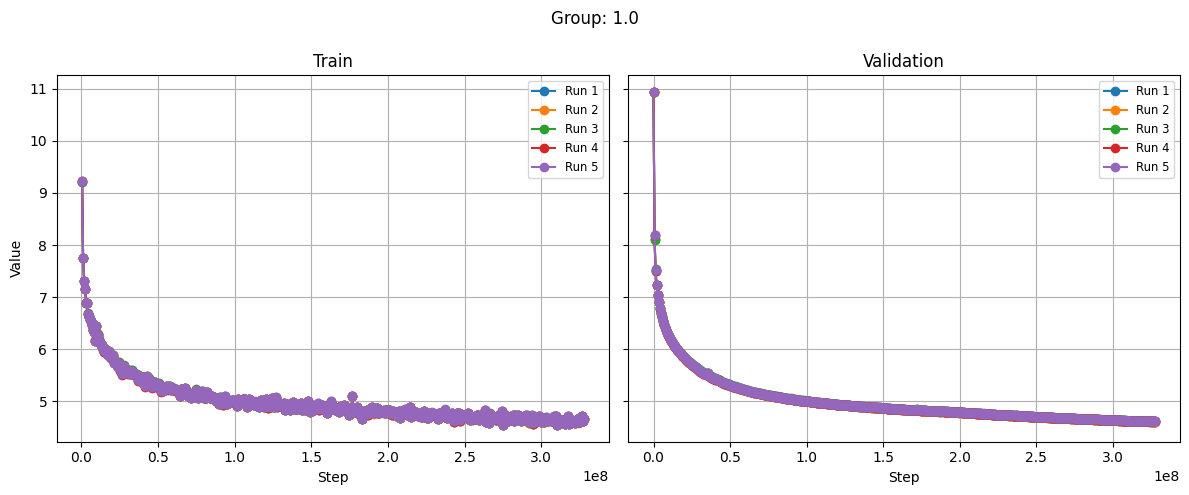

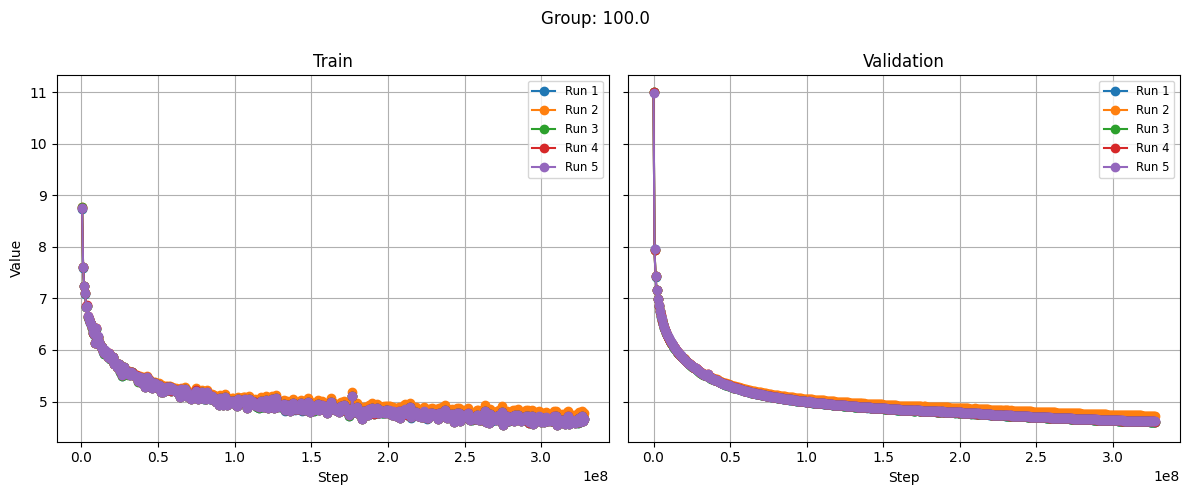

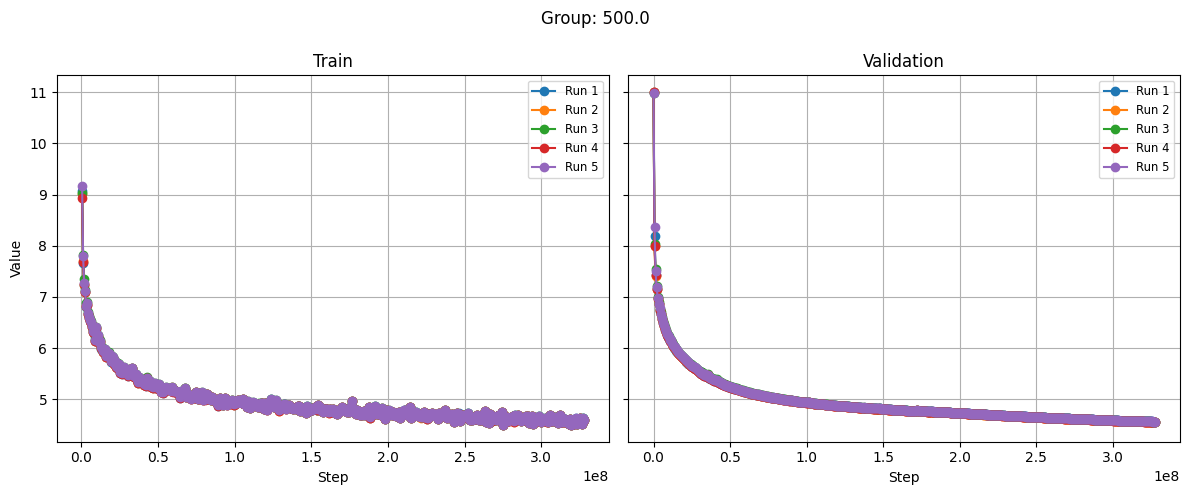

In [53]:
import matplotlib.pyplot as plt

def plot_all_curves(results):
    for group, data in results.items():
        # Create a figure with two subplots (Train and Validation)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        fig.suptitle(f'Group: {group}')
        
        # --- Plot Train curves ---
        for run in data["Train"]:
            steps = [step for step, val in run]
            values = [val for step, val in run]
            axes[0].plot(steps, values, marker='o', label=f'Run {data["Train"].index(run)+1}')
        axes[0].set_title("Train")
        axes[0].set_xlabel("Step")
        axes[0].set_ylabel("Value")
        axes[0].legend(loc='best', fontsize='small')
        axes[0].grid()

        # --- Plot Validation curves ---
        for run in data["Validation"]:
            steps = [step for step, val in run]
            values = [val for step, val in run]
            axes[1].plot(steps, values, marker='o', label=f'Run {data["Validation"].index(run)+1}')
        axes[1].set_title("Validation")
        axes[1].set_xlabel("Step")
        axes[1].legend(loc='best', fontsize='small')
        axes[1].grid()
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Adjust for suptitle
        plt.show()

# Example usage:
plot_all_curves(res_plots)

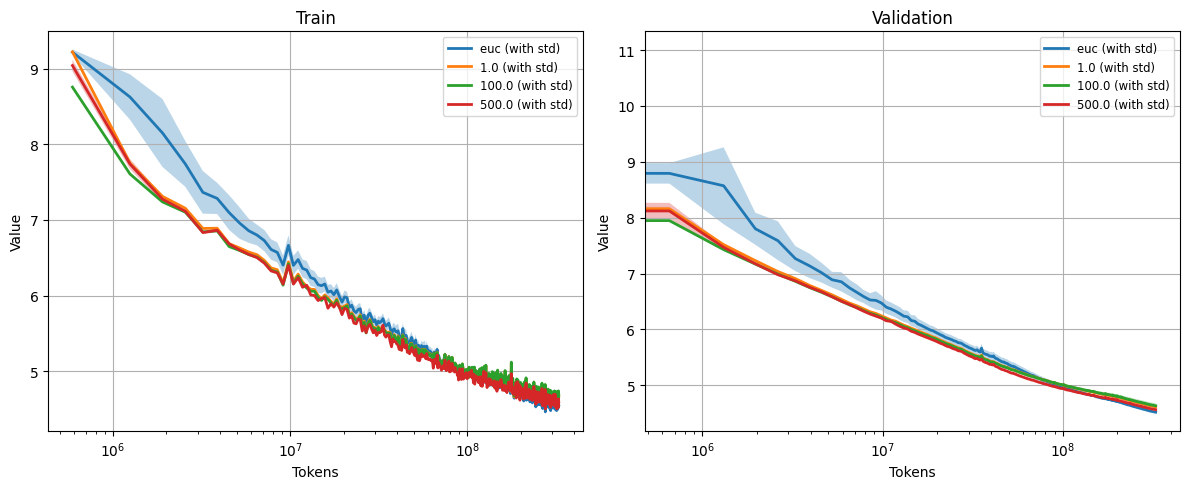

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_val(
    results,
    alpha_fill=0.2,
    x_range=None,
    y_range=None
):
    """
    Plots Train (all groups on one figure) and Validation (all groups on another),
    showing only mean ± std (no individual runs).
    
    Parameters
    ----------
    results : dict
        A dictionary of the form:
            {
              group_name : {
                "Train": [ [(step, val), ...], [(step, val), ...], ... ],
                "Validation": [ [(step, val), ...], [(step, val), ...], ... ]
              },
              ...
            }
    alpha_fill : float, optional
        Transparency for the fill_between shading, by default 0.2
    x_range : tuple or list, optional
        (xmin, xmax) to set the X-axis range, by default None
    y_range : tuple or list, optional
        (ymin, ymax) to set the Y-axis range, by default None
    """
    # --- Create two separate figures: one for Train, one for Validation ---
    fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(12, 5))
    
    for group, data in results.items():
        # --- TRAIN ---
        train_runs = data.get("Train", [])
        if train_runs:
            # Compute mean and std across runs (assuming same steps in each run)
            vals_array = np.array([[val for (_, val) in run] for run in train_runs])
            steps = [step for (step, _) in train_runs[0]]
            mean_vals = vals_array.mean(axis=0)
            std_vals = vals_array.std(axis=0)
            
            # Plot fill + mean
            ax_train.fill_between(steps,
                                  mean_vals - std_vals,
                                  mean_vals + std_vals,
                                  alpha=alpha_fill)
            ax_train.plot(steps, mean_vals, label=f"{group} (with std)", linewidth=2)
        
        # --- VALIDATION ---
        val_runs = data.get("Validation", [])
        if val_runs:
            # Compute mean and std across runs (assuming same steps in each run)
            vals_array = np.array([[val for (_, val) in run] for run in val_runs])
            steps = [step for (step, _) in val_runs[0]]
            mean_vals = vals_array.mean(axis=0)
            std_vals = vals_array.std(axis=0)
            
            # Plot fill + mean
            ax_val.fill_between(steps,
                                mean_vals - std_vals,
                                mean_vals + std_vals,
                                alpha=alpha_fill)
            ax_val.plot(steps, mean_vals, label=f"{group} (with std)", linewidth=2)
    
    # --- Configure axes ---
    # Rename X-axis to "Tokens"
    ax_train.set_xlabel("Tokens")
    ax_train.set_ylabel("Value")
    ax_train.set_title("Train")
    ax_train.grid()
    ax_train.legend(loc='best', fontsize='small')
    
    ax_val.set_xlabel("Tokens")
    ax_val.set_ylabel("Value")
    ax_val.set_title("Validation")
    ax_val.grid()
    ax_val.legend(loc='best', fontsize='small')
    
    # --- Apply range limits if provided ---
    if x_range is not None:
        ax_train.set_xlim(x_range)
        ax_val.set_xlim(x_range)
    if y_range is not None:
        ax_train.set_ylim(y_range)
        ax_val.set_ylim(y_range)

    ax_val.set_xscale('log')
    ax_train.set_xscale('log')
    
    plt.tight_layout()
    plt.show()

plot_train_val(
    results=res_plots,
    alpha_fill=0.3
    # x_range=(1e8, 3e8)
    # y_range=(0, 1.0)
)
